<img src="https://raw.githubusercontent.com/PriyeshGosai/pypsa-meets-earth-lab-2025/main/img/top-banner.png" alt="Top Banner" width="100%">

<div style="display: flex; align-items: center; justify-content: space-between; gap: 30px;">
  <div>
    <h3 style="margin-top: 0;">Session Instructor</h3>
    <p style="margin: 5px 0; font-size: 20px;"><strong>Priyesh Gosai</strong></p>
    <p style="margin: 2px 0; font-size: 14px;">PAS-SA • Director: Energy Systems</p>
    <hr style="margin: 12px 0; border: none; border-top: 1px solid #000000ff;">
    <p style="margin: 6px 0; font-size: 13px;"><a href="mailto:pgosai@pas-sa.co.za">pgosai@pas-sa.co.za</a></p>
    <p style="margin: 6px 0; font-size: 13px;"><a href="https://www.linkedin.com/in/gosaip/">LinkedIn</a> | <a href="https://github.com/PriyeshGosai">GitHub</a> | <a href="https://www.pas-sa.co.za">Website</a></p>
  </div>
  <div>
    <a href="https://pas-sa.co.za/">
      <img src="https://raw.githubusercontent.com/PriyeshGosai/pypsa-meets-earth-lab-2025/main/img/pas-sa-logo.png" width="160" alt="PAS-SA">
    </a>
  </div>
</div>


# **Part 2: Developing a model using Excel**



## Install packages for Google Colab



In [43]:
#@title Connect to Google Drive {display-mode:"form"}
CONNECT_TO_DRIVE = False #@param {type:"boolean"}

from google.colab import drive
import os

if CONNECT_TO_DRIVE:
    # Mount Google Drive
    drive.mount('/content/drive')

    # Define the desired working directory path
    working_dir = '/content/drive/MyDrive/hello-pypsa'

    # Create the directory if it doesn't exist
    if not os.path.exists(working_dir):
        os.makedirs(working_dir)
        print(f"Directory '{working_dir}' created.")
    else:
        print(f"Directory '{working_dir}' already exists.")

    # Change the current working directory
    os.chdir(working_dir)

    print(f"Current working directory: {os.getcwd()}")
else:
    print("Not connecting to Google Drive.")

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
import os

#@title Install Packages {display-mode:"form"}
INSTALL_PACKAGES = True #@param {type:"boolean"}

# Check if packages have already been installed in this session to prevent re-installation
if INSTALL_PACKAGES and not os.environ.get('PYPSA_PACKAGES_INSTALLED'):
  !pip install pypsa pypsa[excel] folium mapclassify cartopy
  os.environ['PYPSA_PACKAGES_INSTALLED'] = 'true'
elif not INSTALL_PACKAGES:
  print("Skipping package installation.")
else:
  print("PyPSA packages are already installed for this session.")

In [ ]:
#@title Download the file for this notebook {display-mode:"form"}
DOWNLOAD_FILE = True #@param {type:"boolean"}

if DOWNLOAD_FILE:
    !wget https://github.com/PriyeshGosai/pypsa-meets-earth-lab-2025/raw/main/network_ZA.xlsx -O network_ZA.xlsx
else:
    print("Skipping file download.")

# Exercise 3

## Example outline

Import a network from an excel file

<img src="https://raw.githubusercontent.com/PriyeshGosai/pypsa-meets-earth-lab-2025/main/img/exercise_program_flow.png" alt="Exercise Program Flow" width="100%">

**Disclaimer**

This analysis employs a South African energy system case study developed exclusively for educational purposes. The model has been intentionally simplified and should not be construed as an accurate or comprehensive representation of the contemporary South African energy system. Consequently, this model is not suitable for application in substantive studies, policy analysis, or operational assessments pertaining to the South African power system.

**Data Sources**

The development of this model incorporates data and information from the following sources:

* DeSantis, D., James, B.D., Houchins, C., Saur, G. and Lyubovsky, M. (2021) 'Cost of long-distance energy transmission by different carriers', *IScience*, 24(12).

* Electric Power Research Institute (EPRI) (2024) 'Supply-Side Cost and Performance Data for Eskom Integrated Resource Planning: 2023–2024 Update', Technical Report 3002031032. Palo Alto, California: EPRI.

* Eskom Transmission Division (2020) *Transmission Development Plan 2020–2029*. Johannesburg, South Africa: Eskom Holdings SOC.

* Merven, B. (2024) 'ESRG Hourly Demand Model v2025 by Province', September. doi: 10.25375/uct.26942134.v5

* Eskom Holdings SOC Ltd (2025) *Eskom*. Available at: https://www.eskom.co.za (Accessed: 24 November 2025).

* Meridian Economics (n.d.) *PyPSA-RSA: An Open Optimisation Model of the South African Power System*. Available at: https://github.com/MeridianEconomics/pypsa-rsa

## Import network

In [44]:
import pypsa
import pandas as pd
pd.set_option('plotting.backend', 'plotly')
pypsa.options.api.new_components_api = True


n_ZA = pypsa.Network('network_ZA.xlsx')


INFO:pypsa.network.io:Imported network 'Unnamed Network' has buses, carriers, generators, links, loads, storage_units


## Inspect network

In [45]:
# Create a Series with MultiIndex (bus, generator_type) containing capacity
gen_capacity_by_type = n_ZA.generators.static.groupby(['bus', 'carrier'])['p_nom'].sum()

# Reshape to have bus as index and carriers as columns
gen_capacity_pivot = n_ZA.generators.static.groupby(['bus', 'carrier'])['p_nom'].sum().unstack(fill_value=0)

# Convert to Series with MultiIndex for bus_split_circle
gen_capacity_multiindex = gen_capacity_pivot.stack()

n_ZA.plot.explore(
    bus_size=gen_capacity_multiindex,
    bus_size_factor=1,  # Adjust scale
    bus_split_circle=True,  # Split into pie-like circles
    bus_color=gen_capacity_multiindex,
    line_color='rosybrown',
    link_color='cyan'
)

{
  "initialViewState": {
    "bearing": 0,
    "latitude": -28.139755555555556,
    "longitude": 26.59628888888889,
    "pitch": 0,
    "zoom": 4
  },
  "layers": [
    {
      "@@type": "PathLayer",
      "autoHighlight": true,
      "data": [
        {
          "bus0": "EC",
          "bus1": "FS",
          "color": "cyan",
          "name": "Eastern Cape to Free State",
          "path": [
            [
              26.4194,
              -32.2968
            ],
            [
              26.8141,
              -28.4541
            ]
          ],
          "rgba": [
            0,
            255,
            255,
            230
          ],
          "tooltip_html": "<b>Eastern Cape to Free State</b>\n<table>\n<tr><td style='font-weight:bold'>bus0:</td><td style='text-align:left'>EC</td></tr>\n<tr><td style='font-weight:bold'>bus1:</td><td style='text-align:left'>FS</td></tr>\n<tr><td style='font-weight:bold'>color:</td><td style='text-align:left'>cyan</td></tr>\n<tr><td style='font-weight:bold'>width:</td><td style='text-align:left'>2</td></tr>\n</table>",
          "width": 2,
          "width_pdk": 2000.0
        },
        {
          "bus0": "EC",
          "bus1": "ZN",
          "color": "cyan",
          "name": "Eastern Cape to KwaZulu-Natal",
          "path": [
            [
              26.4194,
              -32.2968
            ],
            [
              30.5595,
              -28.5306
            ]
          ],
          "rgba": [
            0,
            255,
            255,
            230
          ],
          "tooltip_html": "<b>Eastern Cape to KwaZulu-Natal</b>\n<table>\n<tr><td style='font-weight:bold'>bus0:</td><td style='text-align:left'>EC</td></tr>\n<tr><td style='font-weight:bold'>bus1:</td><td style='text-align:left'>ZN</td></tr>\n<tr><td style='font-weight:bold'>color:</td><td style='text-align:left'>cyan</td></tr>\n<tr><td style='font-weight:bold'>width:</td><td style='text-align:left'>2</td></tr>\n</table>",
          "width": 2,
          "width_pdk": 2000.0
        },
        {
          "bus0": "EC",
          "bus1": "NC",
          "color": "cyan",
          "name": "Eastern Cape to Northern Cape",
          "path": [
            [
              26.4194,
              -32.2968
            ],
            [
              21.8569,
              -29.046
            ]
          ],
          "rgba": [
            0,
            255,
            255,
            230
          ],
          "tooltip_html": "<b>Eastern Cape to Northern Cape</b>\n<table>\n<tr><td style='font-weight:bold'>bus0:</td><td style='text-align:left'>EC</td></tr>\n<tr><td style='font-weight:bold'>bus1:</td><td style='text-align:left'>NC</td></tr>\n<tr><td style='font-weight:bold'>color:</td><td style='text-align:left'>cyan</td></tr>\n<tr><td style='font-weight:bold'>width:</td><td style='text-align:left'>2</td></tr>\n</table>",
          "width": 2,
          "width_pdk": 2000.0
        },
        {
          "bus0": "EC",
          "bus1": "WC",
          "color": "cyan",
          "name": "Eastern Cape to Western Cape",
          "path": [
            [
              26.4194,
              -32.2968
            ],
            [
              19.4294,
              -33.2278
            ]
          ],
          "rgba": [
            0,
            255,
            255,
            230
          ],
          "tooltip_html": "<b>Eastern Cape to Western Cape</b>\n<table>\n<tr><td style='font-weight:bold'>bus0:</td><td style='text-align:left'>EC</td></tr>\n<tr><td style='font-weight:bold'>bus1:</td><td style='text-align:left'>WC</td></tr>\n<tr><td style='font-weight:bold'>color:</td><td style='text-align:left'>cyan</td></tr>\n<tr><td style='font-weight:bold'>width:</td><td style='text-align:left'>2</td></tr>\n</table>",
          "width": 2,
          "width_pdk": 2000.0
        },
        {
          "bus0": "FS",
          "bus1": "GP",
          "color": "cyan",
          "name": "Free State to Gauteng",
       

In [46]:
n_ZA.buses

'Bus' Components
----------------
Attached to PyPSA Network 'Unnamed Network'
Components: 9

In [47]:
n_ZA.generators

'Generator' Components
----------------------
Attached to PyPSA Network 'Unnamed Network'
Components: 24

In [48]:
n_ZA.lines

Empty 'Line' Components

In [49]:
n_ZA.links

'Link' Components
-----------------
Attached to PyPSA Network 'Unnamed Network'
Components: 18

In [50]:
n_ZA.loads

'Load' Components
-----------------
Attached to PyPSA Network 'Unnamed Network'
Components: 9

In [51]:
n_ZA.storage_units

'StorageUnit' Components
------------------------
Attached to PyPSA Network 'Unnamed Network'
Components: 13

## Calculate capital costs

In [52]:
lcoe_ZAR_MW_dict = {'coal':140e6,'gas':10e6,'solar':20e6,'wind':27e6,'battery':26e6}
discount_rate_dict = {'coal':0.08,'gas':0.08,'solar':0.12,'wind':0.12,'battery':0.12}
investment_period = {'coal':40,'gas':20,'solar':15,'wind':15,'battery':12}
annuity_ZAR_MW_dict ,annuity_factor_dict  ={} , {}

for key in lcoe_ZAR_MW_dict:
    annuity_factor_dict[key] = pypsa.common.annuity(discount_rate_dict[key],investment_period[key])
    annuity_ZAR_MW_dict[key] = lcoe_ZAR_MW_dict[key]* annuity_factor_dict[key]





In [53]:
import numpy as np
import pandas as pd

capital_cost_USD_mile_MW = 1502
rate_USD_ZAR = 18
conversion_mile_km = 1.6
capital_cost_ZAR_km_MW = capital_cost_USD_mile_MW*rate_USD_ZAR/conversion_mile_km 

# Get the bus connections
links = n_ZA.links.static[['bus0', 'bus1']].copy()

# Get the bus coordinates
buses = n_ZA.buses.static[['x', 'y']]

# Create a dictionary for quick lookup of bus coordinates
bus_coords = buses.to_dict('index')

# Calculate line lengths
line_lengths = []

for idx, row in links.iterrows():
    bus0 = row['bus0']
    bus1 = row['bus1']
    
    # Get coordinates
    x0, y0 = bus_coords[bus0]['x'], bus_coords[bus0]['y']
    x1, y1 = bus_coords[bus1]['x'], bus_coords[bus1]['y']
    
    # Calculate Euclidean distance in degrees
    length_degrees = np.sqrt((x1 - x0)**2 + (y1 - y0)**2)
    
    # Convert to kilometers
    length_km = length_degrees * 111.32 # Average Earth radius: 6371 km therefore 1 degree at equator ≈ 111.32 km
    line_lengths.append(length_km)

# Add lengths to the links dataframe
links.loc[:, 'length'] = line_lengths

links['links_cost'] = links['length'] * capital_cost_ZAR_km_MW





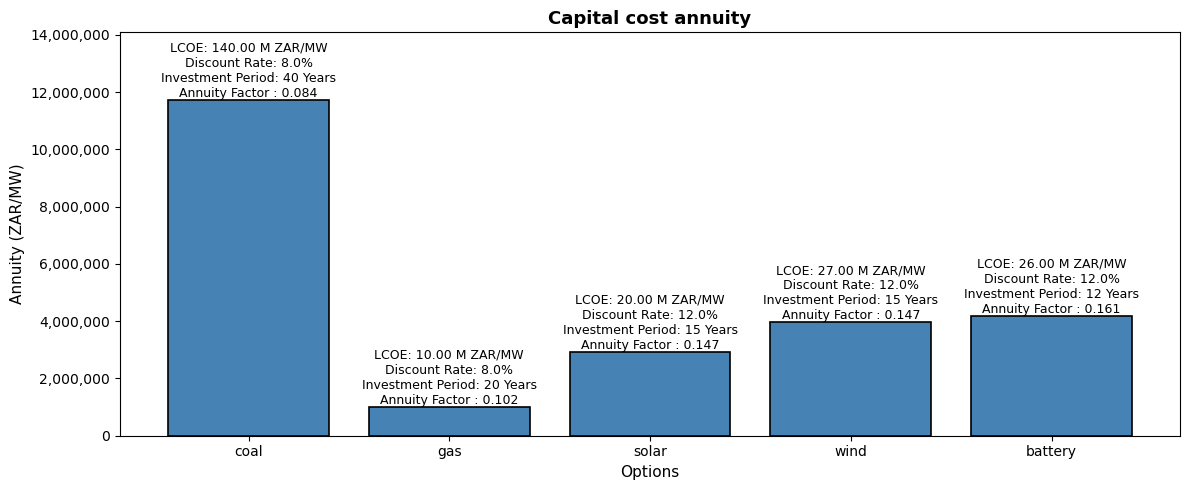

In [54]:
import matplotlib.pyplot as plt
import numpy as np

# Create the plot
fig, ax = plt.subplots(figsize=(12, 5))

# Get keys and values
keys = list(annuity_ZAR_MW_dict.keys())
annuity_values = list(annuity_ZAR_MW_dict.values())

# Create bar chart
bars = ax.bar(keys, annuity_values, color='steelblue', edgecolor='black', linewidth=1.2)

# Remove grid lines
ax.grid(False)

# Add annotations on top of each bar
for i, (key, bar) in enumerate(zip(keys, bars)):
    height = bar.get_height()
    
    # Prepare annotation text
    lcoe_value = lcoe_ZAR_MW_dict[key] * 1e-6  # Scale by 1e-6
    discount_rate_value = discount_rate_dict[key] * 1e2  # Scale by 1e2
    investment_years = investment_period[key]
    annuity_factor = annuity_factor_dict[key]
    
    annotation_text = (
        f"LCOE: {lcoe_value:.2f} M ZAR/MW\n"
        f"Discount Rate: {discount_rate_value:.1f}%\n"
        f"Investment Period: {investment_years} Years\n"
        f"Annuity Factor : {annuity_factor:0.3f}"
    )
    
    # Place text above the bar
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        annotation_text,
        ha='center',
        va='bottom',
        fontsize=9,
        # bbox=dict(boxstyle='round,pad=0.5', facecolor='lightyellow', edgecolor='gray', alpha=0.8)
    )

# Labels and title
ax.set_ylabel('Annuity (ZAR/MW)', fontsize=11)
ax.set_xlabel('Options', fontsize=11)
ax.set_title('Capital cost annuity', fontsize=13, fontweight='bold')
ax.set_ylim(0,max(annuity_ZAR_MW_dict.values())*1.2)
ax.ticklabel_format(style='plain', axis='y')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))

plt.tight_layout()
plt.show()

## Update the model

In [55]:
n_ZA.generators.static['p_nom_min'] = n_ZA.generators.static['p_nom']
n_ZA.links.static['p_nom_min'] = n_ZA.links.static['p_nom']
n_ZA.storage_units.static['p_nom_min'] = n_ZA.storage_units.static['p_nom']

n_ZA.storage_units.static.loc[n_ZA.storage_units.static['carrier'] == 'battery', 'capital_cost'] = annuity_ZAR_MW_dict['battery']
n_ZA.links.static.loc[:,'capital_cost'] = links['links_cost']
n_ZA.generators.static['capital_cost'] = n_ZA.generators.static['carrier'].map(annuity_ZAR_MW_dict)

## Simplify the model

In [56]:
month = 4

n_ZA.snapshots = n_ZA.snapshots[(n_ZA.snapshots.month == month)]
n_months = n_ZA.snapshots.to_period('M').nunique()/12


n_ZA.links.static['capital_cost'] = n_ZA.links.static['capital_cost'] / 12
n_ZA.generators.static['capital_cost'] = n_ZA.generators.static['capital_cost'] / 12
n_ZA.storage_units.static['capital_cost'] = n_ZA.storage_units.static['capital_cost'] / 12

## Scenarios

Consider four scenarios.

* **Scenario 1**

    Determine the dispatch for the plant if no new generation is added.

    In this case you will need to add loadshedding generators as there is insufficient capacity. 

* **Scenario 2**

    Determine the optimal nominal power if we optimise for generation capacity. 


* **Scenario 3**

    Determine the optimal nominal power if we co-optimise generation and transmission capacity. 

* **Scenario 4**

    Determine the optimal nominal power if we co-optimise generation, transmission and storage capacity. 

    This simulation will take approximately 6 minutes to solve. 

_Note:_
_For all scenarios, consider including a carbon constraint_



**Code for exercises**


This is a method in PyPSA that adds loadshedding busses in the case that there is insufficient capacity to meet demand. Only use this in Scenario 1.

```
n_ZA.optimize.add_load_shedding(buses = n_ZA.buses.static.index,marginal_cost = 10000)
```

Adjust the CO2 Global Constraint

```
co2_limit = 6e6*12 # tonnes/year 
n_ZA.add("GlobalConstraint","CO2_limit",carrier_attribute="co2_emissions",sense="<=",constant=co2_limit*n_months)
```

We can use these pandas commands to set the p_nom_extendable status for generators, links, lines (not used in this example) or storage_units. 

```
n_ZA.generators.static['p_nom_extendable'] = False

n_ZA.links.static['p_nom_extendable'] = False

n_ZA.storage_units.static.loc[n_ZA.storage_units.static['carrier'] == 'battery', 'p_nom_extendable'] = False
```

For the case of generators, you may want to only make generators associated with specific carriers extendable. 

```
n_ZA.generators.static.loc[(n_ZA.generators.static['carrier'] == 'solar') | 
                            (n_ZA.generators.static['carrier'] == 'wind') |
                            (n_ZA.generators.static['carrier'] == 'gas'), 'p_nom_extendable'] = True    
```

In [ ]:
# n_ZA.optimize.add_load_shedding(buses = n_ZA.buses.static.index,marginal_cost = 10000)

# co2_limit = 6e6*12 # tonnes/year 
# n_ZA.add("GlobalConstraint","CO2_limit",carrier_attribute="co2_emissions",sense="<=",constant=co2_limit*n_months)

# n_ZA.generators.static['p_nom_extendable'] = True
# n_ZA.generators.static.loc[(n_ZA.generators.static['carrier'] == 'solar') | 
#                             (n_ZA.generators.static['carrier'] == 'wind') |
#                             (n_ZA.generators.static['carrier'] == 'gas'), 'p_nom_extendable'] = False  

# n_ZA.links.static['p_nom_extendable'] = False

# n_ZA.storage_units.static.loc[n_ZA.storage_units.static['carrier'] == 'battery', 'p_nom_extendable'] = False



## Solve network

In [58]:
n_ZA.optimize()

Index(['EC load shedding', 'FS load shedding', 'GP load shedding',
       'ZN load shedding', 'LP load shedding', 'MP load shedding',
       'NW load shedding', 'NC load shedding', 'WC load shedding'],
      dtype='object', name='name')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 5/5 [00:00<00:00, 57.76it/s]
INFO:linopy.io: Writing time: 0.68s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 64890 primals, 193162 duals
Objective: 2.78e+13
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-fix-p-ramp_limit_up, Generator-fix-p-ramp_limit_down, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-stat

('ok', 'optimal')

## Postprocess results

In [59]:
df_p_nom_gen_opt = n_ZA.generators.static['p_nom_opt']
df_p_nom_gen_opt = df_p_nom_gen_opt.drop(df_p_nom_gen_opt[df_p_nom_gen_opt.index.str.contains('load shedding')].index)
df_p_nom_tx_opt = n_ZA.links.static['p_nom_opt']
df_p_nom_bess_opt = n_ZA.storage_units.static['p_nom_opt']

Calculate total emissions

In [60]:
total_emissions = 0

for gen in n_ZA.generators.static.index:
    carrier = n_ZA.generators.static.loc[gen, 'carrier']
    efficiency = n_ZA.generators.static.loc[gen, 'efficiency']
    
    # Skip if carrier doesn't exist in the carriers table
    if carrier not in n_ZA.carriers.static.index:
        print(f"Warning: Carrier '{carrier}' not found in carriers table, skipping generator '{gen}'")
        continue
    
    co2_emissions_factor = n_ZA.carriers.static.loc[carrier, 'co2_emissions']
    
    # Get the dispatch time series
    dispatch = n_ZA.generators.dynamic.p[gen]
    
    # Calculate emissions: (dispatch / efficiency) * emission_factor
    gen_emissions = (dispatch / efficiency) * co2_emissions_factor
    
    total_emissions += gen_emissions.sum()

print(f"Total CO2 Emissions: {total_emissions:.2f} tCO2")

Total CO2 Emissions: 14026149.52 tCO2


In [61]:
n_ZA.generators.dynamic.p

name,CFPP Mpumalanga,CFPP Free State,CFPP Limpopo,Solar Eastern Cape,Solar Free State,Solar Gauteng,Solar KwaZulu-Natal,Solar Limpopo,Solar Mpumalanga,Solar North West,...,CCGT KZN,EC load shedding,FS load shedding,GP load shedding,ZN load shedding,LP load shedding,MP load shedding,NW load shedding,NC load shedding,WC load shedding
snapshot,,,,,,,,,,,,,,,,,,,,,
2024-04-01 00:00:00.000,4984.839016,2996.064000,8310.000000,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,3000.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,3.855227e+06,-0.0,-0.0
2024-04-01 01:00:00.000,5582.079016,3055.392000,8310.000000,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,3000.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,3.855227e+06,-0.0,-0.0
2024-04-01 02:00:00.000,6179.319016,3114.720000,8310.000000,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,3000.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,3.855227e+06,-0.0,-0.0
2024-04-01 03:00:00.000,6776.559016,3174.048000,8287.562827,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,3000.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,3.855227e+06,-0.0,-0.0
2024-04-01 04:00:00.000,7373.799016,3233.376000,8310.000000,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,3000.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,3.855227e+06,-0.0,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-30 19:59:59.999,9367.758012,2981.207683,7900.502726,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,3000.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,3.855227e+06,-0.0,-0.0
2024-04-30 20:59:59.999,8770.518012,2921.879683,7318.802726,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,3000.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,3.855227e+06,-0.0,-0.0
2024-04-30 21:59:59.999,8173.278012,2862.551683,6737.102726,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,3000.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,3.855227e+06,-0.0,-0.0


## Observe model outputs

## Plot key results

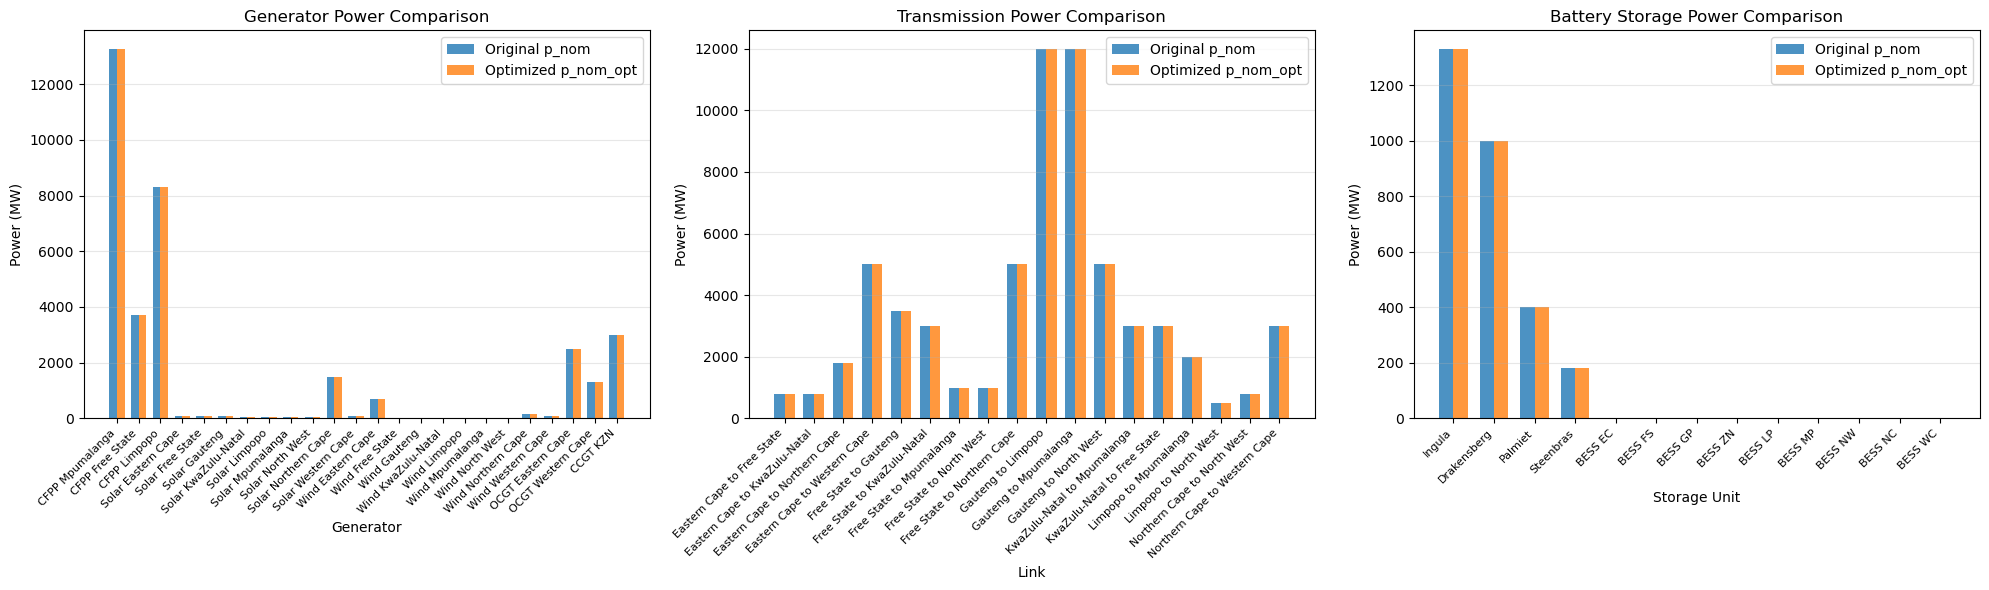

In [62]:
# Extract original p_nom values
df_p_nom_gen = n_ZA.generators.static['p_nom']
df_p_nom_gen = df_p_nom_gen.drop(df_p_nom_gen[df_p_nom_gen.index.str.contains('load shedding')].index)

df_p_nom_tx = n_ZA.links.static['p_nom']
df_p_nom_bess = n_ZA.storage_units.static['p_nom']

# Switch to matplotlib backend
pd.set_option('plotting.backend', 'matplotlib')

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))

# Plot 1: Generators
x = range(len(df_p_nom_gen))
width = 0.35
axes[0].bar([i - width/2 for i in x], df_p_nom_gen, width, label='Original p_nom', alpha=0.8)
axes[0].bar([i + width/2 for i in x], df_p_nom_gen_opt, width, label='Optimized p_nom_opt', alpha=0.8)
axes[0].set_title('Generator Power Comparison')
axes[0].set_ylabel('Power (MW)')
axes[0].set_xlabel('Generator')
axes[0].set_xticks(x)
axes[0].set_xticklabels(df_p_nom_gen.index, rotation=45, ha='right', fontsize=8)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Plot 2: Transmission
x = range(len(df_p_nom_tx))
width = 0.35
axes[1].bar([i - width/2 for i in x], df_p_nom_tx, width, label='Original p_nom', alpha=0.8)
axes[1].bar([i + width/2 for i in x], df_p_nom_tx_opt, width, label='Optimized p_nom_opt', alpha=0.8)
axes[1].set_title('Transmission Power Comparison')
axes[1].set_ylabel('Power (MW)')
axes[1].set_xlabel('Link')
axes[1].set_xticks(x)
axes[1].set_xticklabels(df_p_nom_tx.index, rotation=45, ha='right', fontsize=8)
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

# Plot 3: Battery Storage
x = range(len(df_p_nom_bess))
width = 0.35
axes[2].bar([i - width/2 for i in x], df_p_nom_bess, width, label='Original p_nom', alpha=0.8)
axes[2].bar([i + width/2 for i in x], df_p_nom_bess_opt, width, label='Optimized p_nom_opt', alpha=0.8)
axes[2].set_title('Battery Storage Power Comparison')
axes[2].set_ylabel('Power (MW)')
axes[2].set_xlabel('Storage Unit')
axes[2].set_xticks(x)
axes[2].set_xticklabels(df_p_nom_bess.index, rotation=45, ha='right', fontsize=8)
axes[2].legend()
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Switch back to plotly if needed
pd.set_option('plotting.backend', 'plotly')

## Explore the statistics library

In [63]:
n_ZA.statistics.energy_balance.iplot(kind = 'area')

ConsistencyError: The following generators have carriers which are not defined:
Index(['EC load shedding', 'FS load shedding', 'GP load shedding',
       'ZN load shedding', 'LP load shedding', 'MP load shedding',
       'NW load shedding', 'NC load shedding', 'WC load shedding'],
      dtype='object', name='name')

In [ ]:
n_ZA.statistics.capacity_factor.iplot()
